In [269]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [270]:
import flopy
import flopy.utils.binaryfile as bf


In [271]:
## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge\Projects C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel


## Plotting head raster and contours

In [272]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/'
model_ws = loadpth+'Permeameter_for_velocity'

In [273]:

name = 'MF.nam'
# name = 'MF_child.nam'
m = flopy.modflow.Modflow.load(name, model_ws=model_ws, 
                                exe_name='mf2005', version='mf2005')


In [7]:
def plot_head(model, hdobj, cbb, spd_stp,time, name, ax, hk):
    head = hdobj.get_data(kstpkper = spd_stp)
    levels_hmax = np.round(np.max(head[head!=1E+30]),-1)
#     levels_hmin = np.round(np.min(head[head!=-999.99]),-1)
    levels_hmin = np.round(np.min(head[head>=-200]),-1)
    levels = np.arange(levels_hmin, levels_hmax, 5)

    ax.set_title(name+' Head Contours at '+ str(time))
    mapview = flopy.plot.PlotMapView(model=model,ax=ax)
    
    contour_set = mapview.contour_array(head, masked_values=[-999.99], levels=levels, ax=ax)
    hcb = plt.colorbar(contour_set, shrink = 0.5,ax=ax)
    hcb.set_label('Head (m)')
#     ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)

    # plot the horizontal hydraulic conductivities
    if hk == True:
        a = model.lpf.hk.array
        csa = mapview.plot_array(a, norm=mpl.colors.LogNorm())
        cb = plt.colorbar(csa, shrink=0.75,ax=ax)
        cb.set_label('Horiz. Cond. (m/d)')
    mapview.plot_bc("CHD", plotAll=True)
    
    frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
    fff = cbb.get_data(text='FLOW FRONT FACE')[0]
    quiver = mapview.plot_vector(frf, fff, istep=1000, jstep=1000)  # no head array for volumetric discharge

    ax.ticklabel_format(style='plain')
    linecollection = mapview.plot_grid(linewidths = 0.3)
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
#     plt.savefig('Plots//'+name +'_head_contour.png', dpi = 600, bbox_inches='tight')

In [8]:
# cbb = flopy.utils.CellBudgetFile(model_ws+'/MF.upw.cbc')
cbb = flopy.utils.CellBudgetFile(model_ws+'/MF.cbc')

hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()


In [9]:
# create dates to match totim
# strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = strt_date+pd.DateOffset(months=m.dis.nper-1)
# dates = strt_date+pd.to_timedelta(zb_df.index-1, unit = 'days')

In [10]:
# create dataframe referencing between date, totim and kstp,kper
# time_spd = pd.DataFrame(np.transpose(np.array([times,spd_stp],dtype='object')),columns = ['totim','spd_stp'])
# time_spd.index = dates
# time_spd.totim = pd.to_numeric(time_spd.totim)

## Velocity Analysis

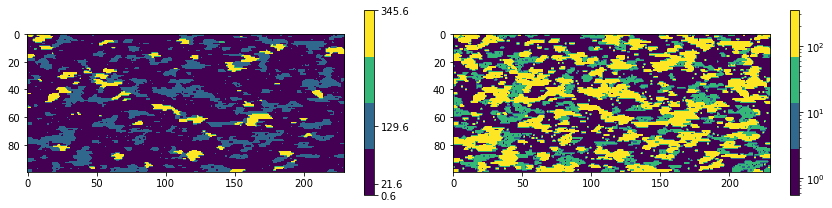

In [252]:
fig,ax = plt.subplots(1,2,figsize=(12,3))
K = m.lpf.hk.array
cmap = plt.get_cmap('viridis',4)
im = ax[0].imshow(K[0,:,:],  cmap=cmap)
plt.colorbar(mappable = im, ax = ax[0], ticks = np.unique(K))

im=ax[1].imshow(K[0,:,:], norm = mpl.colors.LogNorm(), cmap=cmap)
plt.colorbar(mappable = im, ax = ax[1])
fig.tight_layout()

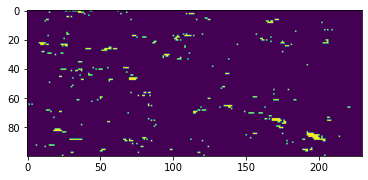

In [259]:
qz_plt = np.zeros(qz.shape)
qz_plt[qz>np.percentile(qz, [50])] =1
plt.imshow(qz_plt[0,:,:])

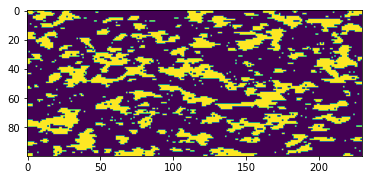

In [263]:
K_c = np.zeros(K.shape)
K_c[(K==np.unique(K)[-2])|(K==np.unique(K)[-1])] = 1
plt.imshow(K_c[0,:,:])

In [187]:
# fig,ax = plt.subplots(figsize=(8,8))

# mapview = flopy.plot.PlotMapView(model=m,ax=ax)
# linecollection = mapview.plot_grid(linewidths = 0.1)

extcbb = flopy.utils.postprocessing.get_extended_budget(cbb)

(qx, qy, qz) = flopy.utils.postprocessing.get_specific_discharge(vectors = extcbb, model=m)
# mapview.plot_vector(qx, qy, istep=10, jstep=10)
qz *= -1
qy *= -1
qx *= -1

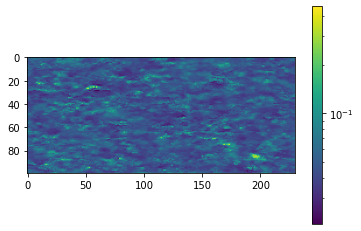

In [181]:
plt.imshow(qz[0,:,:]*-1, norm=mpl.colors.LogNorm())
plt.colorbar()

In [256]:
# get percentiles to determine which to plot
qz_quants = np.percentile(qz, [0,25,50,75,99,99.9])
qz_quants

array([0.02073447, 0.08407731, 0.09596906, 0.11246872, 0.20386947,
       0.36971602])

# MPL 3D plotting

In [ ]:
fig = plt.figure()
# syntax for 3-D projection
ax = plt.axes(projection ='3d')


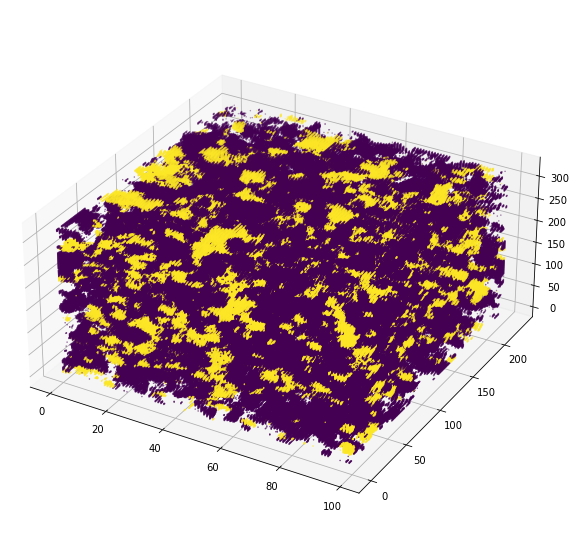

In [74]:
K = m.lpf.hk.array
vals = np.unique(K)
z, x, y = np.where((K==vals[2])|(K==vals[3]))
# z, x, y = np.where((K==vals[3]))

c = K[z,x,y]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
 
ax.scatter(x, y, z, c = c, s = 0.2)
# ax.contour3D(x, y, z)

ax.set_box_aspect((1, 1,1/2))

In [67]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 3))
x = np.linspace(-1, 5, 10)
y = np.linspace(-1, 5, 10)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
X.shape, Y.shape, Z.shape
x


array([-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
        2.33333333,  3.        ,  3.66666667,  4.33333333,  5.        ])

In [68]:
x = np.arange(1, 101)
y = np.arange(1, 231)
X, Y = np.meshgrid(x, y)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

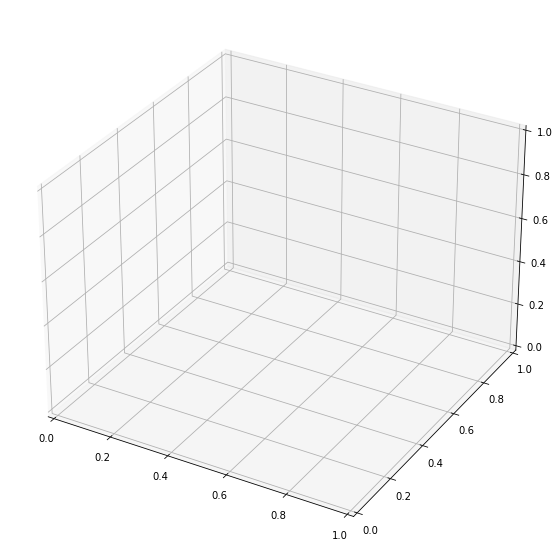

In [72]:


fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
 
ax.scatter(x, y, z, c = c, s = 0.2)
# ax.contour3D(x, y, z)

ax.set_box_aspect((1, 1,1/2))

## Interactive Plotting

In [274]:
# sphinx_gallery_thumbnail_number = 2
import pyvista as pv
from pyvista import examples
import numpy as np

In [275]:
from itkwidgets import view

In [276]:
# so far only ipyvtklink works
pv.set_jupyter_backend(backend='ipyvtklink')

## Grid

In [277]:
values.shape

(20, 5, 10)

In [278]:
#nx, ny, nz
values = np.linspace(0, 10, 1000).reshape((20, 5, 10))
values.shape

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

# Edit the spatial reference
grid.origin = (100, 33, 55.6)  # The bottom left corner of the data set
grid.spacing = (1, 5, 2)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_data["values"] = values.flatten(order="F")  # Flatten the array!

# Now plot the grid!
grid.plot(show_edges=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [96]:
import vtk
import pyvista

In [166]:
grid = pyvista.RectilinearGrid()

In [167]:
vtkgrid = vtk.vtkRectilinearGrid()
grid = pyvista.RectilinearGrid(vtkgrid)

In [168]:
K = m.lpf.hk.array
K = np.transpose(K, (1,2,0))

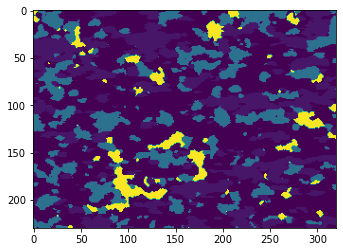

In [176]:
plt.imshow(K[0,:,:])

In [169]:
x = np.linspace(0,100*2,101)
y = np.linspace(0,230*2,231)
z = np.linspace(-80,80,321)
grid = pyvista.RectilinearGrid(x,y,z)

In [170]:
grid.origin = [0,0,0]


In [171]:
grid.cell_data['values'] = K.flatten(order="C")

In [172]:
grid.plot(show_edges=True, show_grid=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)